# Imports

In [1]:
import cudf as pd
import dask
import numpy as np
import pandas
import shap
import seaborn as sns
import numpy
import cupy
import tensorflow
import os
import random
from cuml import RandomForestRegressor as CudaRandomForest
from cuml.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from shap.plots import colors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

SEED = 100


def reset_seed(rnd_seed=SEED):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(rnd_seed)
    numpy.random.seed(rnd_seed)
    cupy.random.seed(rnd_seed)
    tensorflow.random.set_seed(rnd_seed)


reset_seed()


2024-07-19 10:32:33.074916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 10:32:33.074977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 10:32:33.159292: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-19 10:32:33.223129: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Datasets

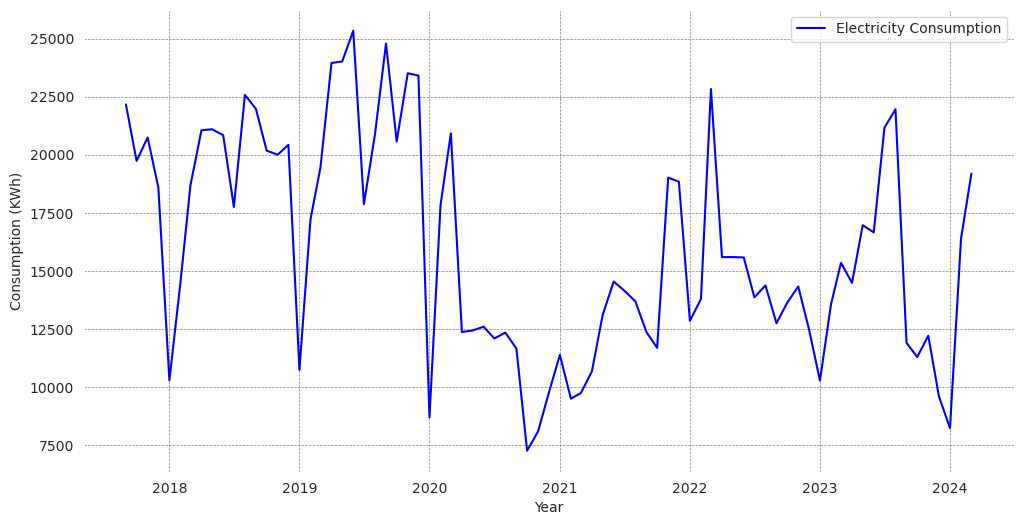

In [2]:
df_electricity = pd.read_csv('dataset/electricity.csv', sep=";", decimal=".", header=0)
df_climatic = pd.read_csv('dataset/climatic.csv', sep=";", decimal=".", header=0)

df_electricity["date"] = pd.to_datetime(df_electricity["date"], format="%d/%m/%Y")
df_climatic["date"] = pd.to_datetime(df_climatic["date"], format="%d/%m/%Y")

df_electricity.set_index("date", inplace=True)
df_climatic.set_index("date", inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df_electricity["consumption"], label="Electricity Consumption", color="blue")
plt.xlabel('Year')
plt.ylabel('Consumption (KWh)')

ax = plt.gca()
ax.set_facecolor('white')
plt.grid(True, color='grey', linestyle="--", linewidth=0.5)
plt.legend(facecolor='white')
plt.show()
    

# Pré-Processamento

## Dados climáticos faltantes

In [3]:
for index, row in df_climatic[df_climatic.isnull()].to_pandas().iterrows():
    df_mes = df_climatic[df_climatic["month"] == df_climatic.at[index, "month"]]
    for col in row.index:
        if pandas.isnull(df_climatic.at[index, col]):
            df_mes.at[index, col] = df_mes[col].sum() / df_mes[col][df_mes[col].isnull() == False].count()
            df_climatic.at[index, col] = df_mes.at[index, col]

## Obtenção dos LAGS

In [4]:
for lag_col in ["consumption"]:
    for i in range(1, 12 + 1):
        lag_eletricity = df_electricity[lag_col].shift(i)
        df_electricity[f'LAG_' + '{:02d}'.format(i)] = lag_eletricity

## União dos dados climáticos aos dados de consumption

In [5]:
df_electricity = pd.merge(left=df_electricity, right=df_climatic, on=["date", "month", "year"], how="left")
df_electricity = df_electricity.drop("date_measure", axis=1)


## Criação das variáveis Dummy (mês e ano)

In [6]:
df_meses = pd.get_dummies(df_electricity["month"].astype(int), prefix="", prefix_sep="", dtype=int).rename(
    columns={"1": "month_JAN", "2": "month_FEV", "3": "month_MAR", "4": "month_ABR", "5": "month_MAI", "6": "month_JUN",
             "7": "month_JUL", "8": "month_AGO", "9": "month_SET", "10": "month_OUT", "11": "month_NOV",
             "12": "month_DEZ"}
)
df_anos = pd.get_dummies(df_electricity["year"].astype(int), prefix="", prefix_sep="", dtype=int).rename(
    columns={"2017": "year_2017", "2018": "year_2018", "2019": "year_2019", "2020": "year_2020", "2021": "year_2021",
             "2022": "year_2022", "2023": "year_2023", "2024": "year_2024"}
)
df_electricity = pd.concat([df_electricity, df_meses, df_anos], axis=1)
df_electricity = df_electricity.drop(["month", "year"], axis=1)
df_electricity = df_electricity.astype("float32").dropna()

df_show = df_electricity.to_pandas()
df_show

,consumption,LAG_01,LAG_02,LAG_03,LAG_04,LAG_05,LAG_06,LAG_07,LAG_08,LAG_09,...,month_NOV,month_DEZ,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,10732.0,20426.0,19998.0,20174.0,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-02-01,17208.0,10732.0,20426.0,19998.0,20174.0,21969.0,22575.0,17751.0,20841.0,21095.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-03-01,19451.0,17208.0,10732.0,20426.0,19998.0,20174.0,21969.0,22575.0,17751.0,20841.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-04-01,23949.0,19451.0,17208.0,10732.0,20426.0,19998.0,20174.0,21969.0,22575.0,17751.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-05-01,24015.0,23949.0,19451.0,17208.0,10732.0,20426.0,19998.0,20174.0,21969.0,22575.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,12207.0,11286.0,11897.0,21955.0,21165.0,16655.0,16964.0,14480.0,15342.0,13555.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2023-12-01,9588.0,12207.0,11286.0,11897.0,21955.0,21165.0,16655.0,16964.0,14480.0,15342.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-01-01,8226.0,9588.0,12207.0,11286.0,11897.0,21955.0,21165.0,16655.0,16964.0,14480.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Análise de Correlações


### Correlação com os LAGS

<Axes: >

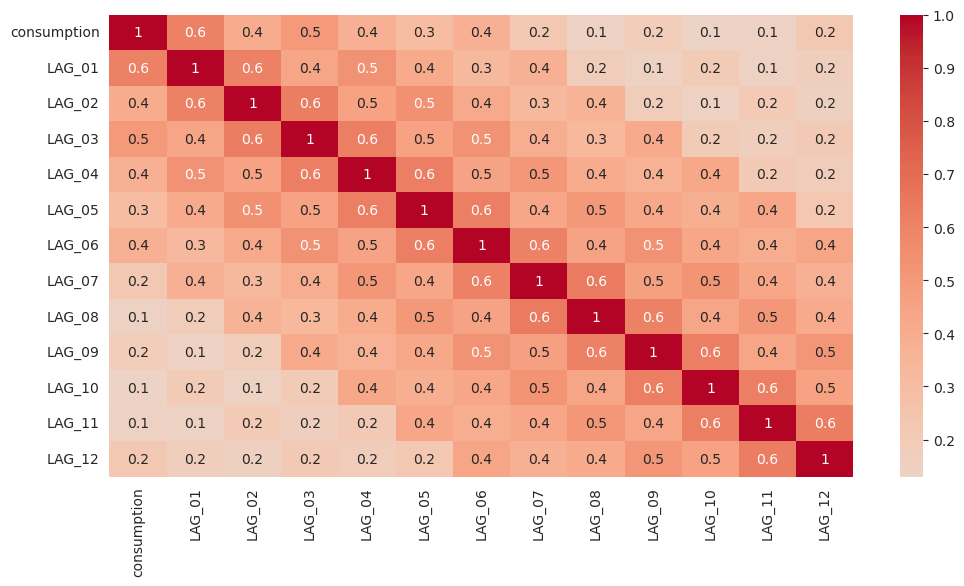

In [7]:
columns = df_electricity.to_pandas().filter(like="LAG_").columns.tolist()
columns.insert(0, "consumption")

corr_matrix = df_electricity[columns].dropna().to_pandas().corr(
    numeric_only=True)

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g',
            ax=ax)

### Correlação com as variáveis climáticas

<Axes: >

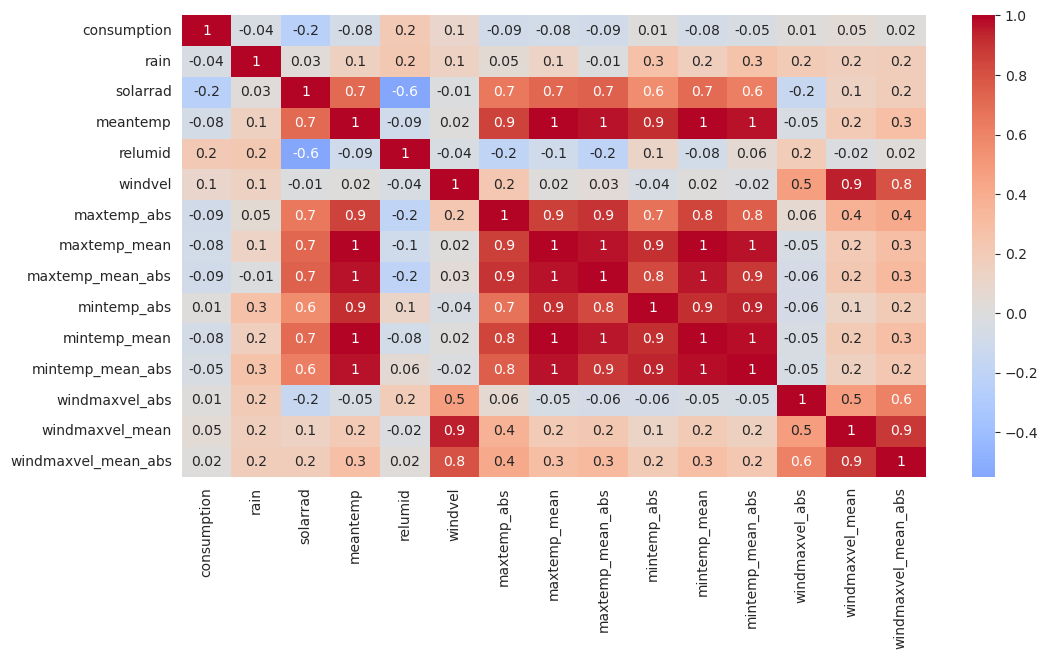

In [8]:
corr_matrix = df_electricity.drop(df_electricity.to_pandas().filter(like="LAG_").columns,
                                  axis=1).drop(df_electricity.to_pandas().filter(like="month_").columns,
                                               axis=1).drop(df_electricity.to_pandas().filter(like="year_").columns,
                                                            axis=1).drop(
    df_electricity.to_pandas().filter(like="covid").columns,
    axis=1).dropna().to_pandas().corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g',
            ax=ax)

# Análise dos SHAP values


### Random Forest

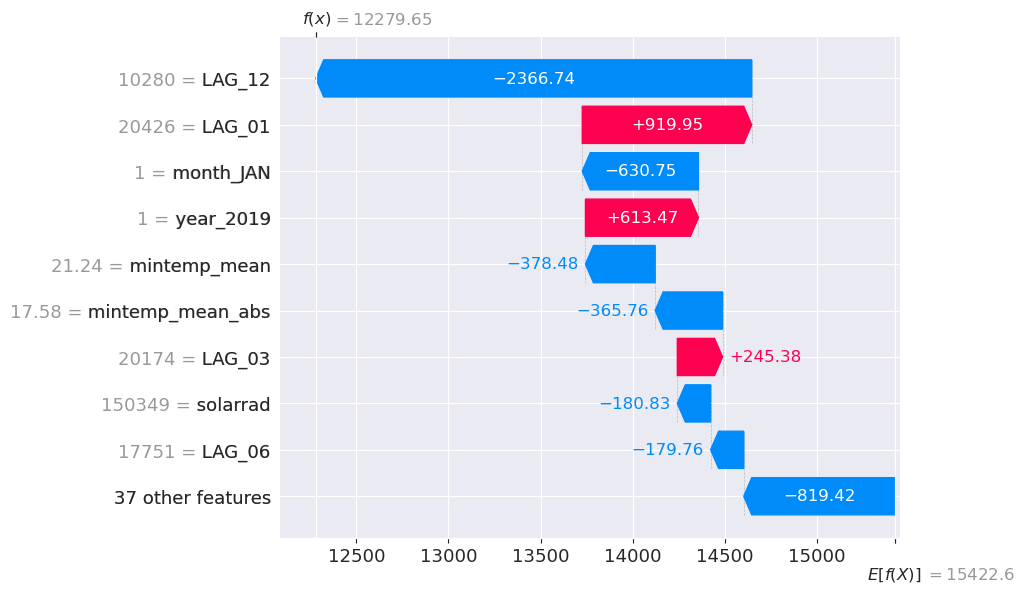

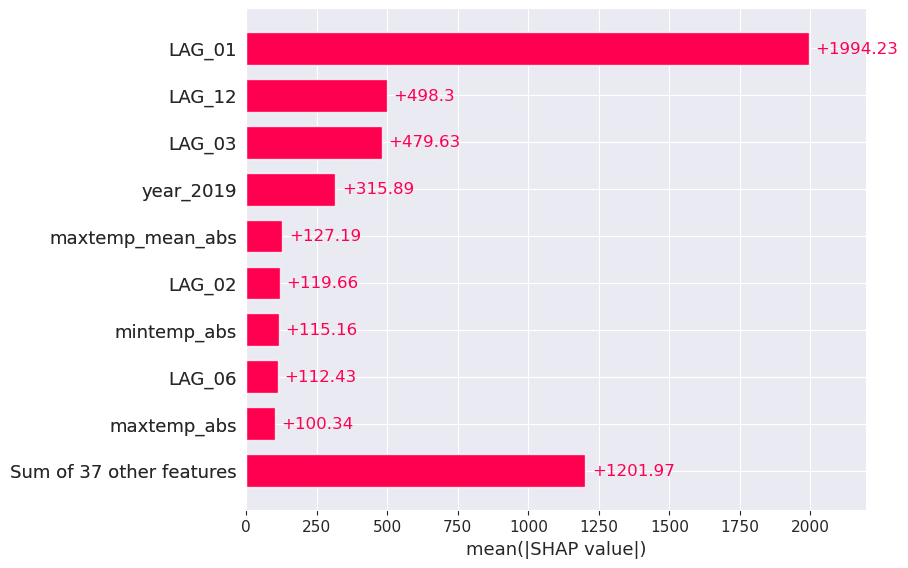

,feature,rf importance
38,year_2017,0.000000
33,month_AGO,1.028522
35,month_OUT,1.677681
31,month_JUN,1.794234
34,month_SET,2.308957
44,year_2023,3.028832
37,month_DEZ,3.304393
30,month_MAI,4.152350
42,year_2021,4.273225
32,month_JUL,4.599330


In [9]:
df_electricity_copy = df_electricity.copy().to_pandas()

x_electricity = df_electricity_copy.drop("consumption", axis=1)
y_electricity = df_electricity_copy["consumption"]
model_rf_electr = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=SEED)
shap.initjs()

model_rf_electr.fit(x_electricity, y_electricity)

explainer_rf_electr = shap.Explainer(model_rf_electr)
shap_rf_electr = explainer_rf_electr(x_electricity)

shap.plots.waterfall(shap_rf_electr[0], max_display=10)
shap.plots.force(shap_rf_electr[0])
shap.plots.bar(shap_rf_electr)

importance_rf_electr = pandas.DataFrame(list(zip(x_electricity.columns, numpy.abs(shap_rf_electr.values).mean(0))),
                                        columns=["feature", "rf importance"])
importance_rf_electr = importance_rf_electr.sort_values(by=["rf importance"])
importance_rf_electr

### XGBoost

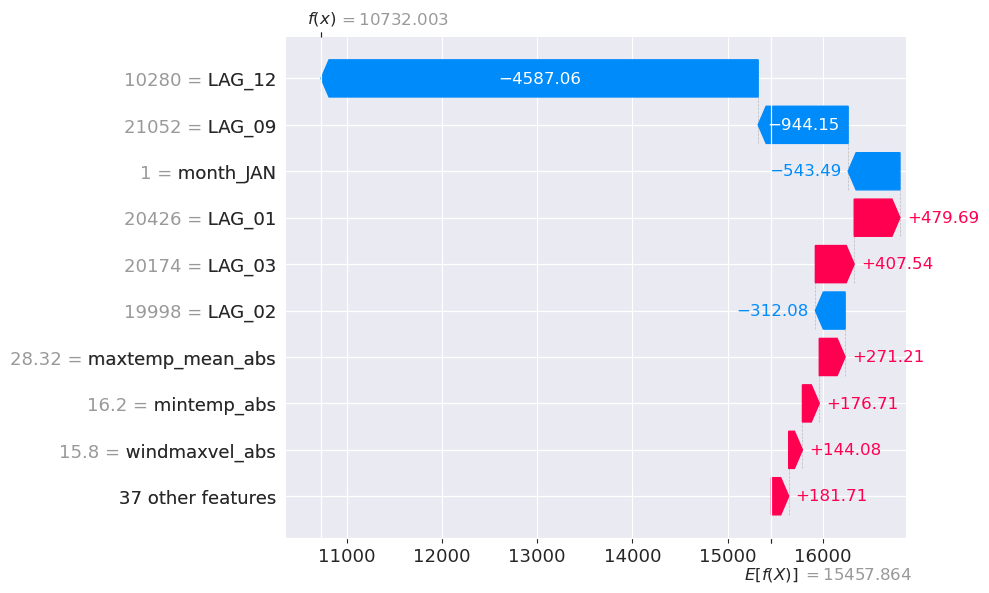

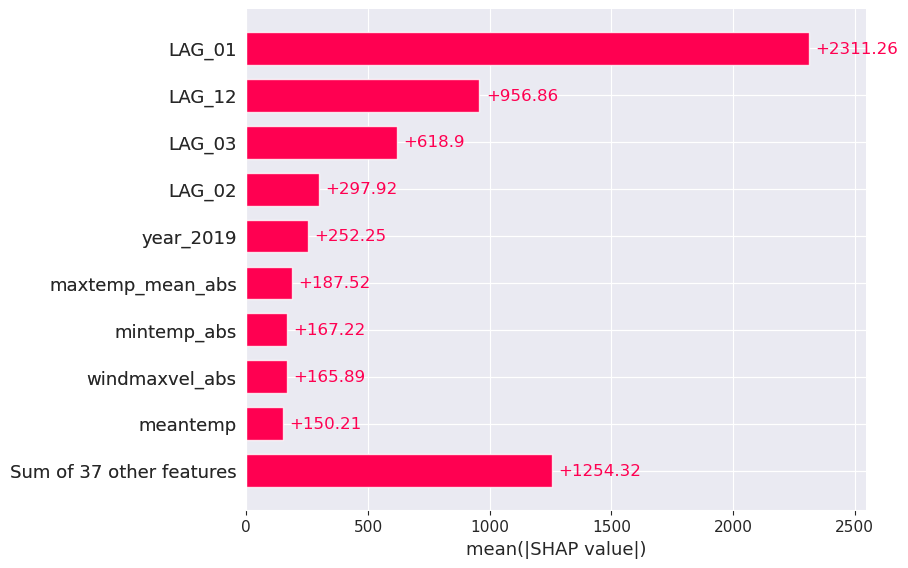

,feature,xgb importance
45,year_2024,0.000000
32,month_JUL,0.000000
33,month_AGO,0.000000
37,month_DEZ,0.000000
31,month_JUN,0.000000
42,year_2021,0.000000
43,year_2022,0.000000
38,year_2017,0.000000
21,mintemp_mean,0.000039
29,month_ABR,0.000727


In [10]:
df_electricity_copy = df_electricity.copy().to_pandas()

x_electricity = df_electricity_copy.drop("consumption", axis=1)
y_electricity = df_electricity_copy["consumption"]

model_xgb_electr = XGBRegressor(booster="gbtree", objective='reg:squarederror', random_state=SEED)
shap.initjs()

model_xgb_electr.fit(x_electricity, y_electricity)

explainer_xgb_electr = shap.Explainer(model_xgb_electr)
shap_xgb_electr = explainer_xgb_electr(x_electricity)

shap.plots.waterfall(shap_xgb_electr[0], max_display=10)
shap.plots.force(shap_xgb_electr[0])
shap.plots.bar(shap_xgb_electr)

importance_xgb_electr = pandas.DataFrame(list(zip(x_electricity.columns, numpy.abs(shap_xgb_electr.values).mean(0))),
                                         columns=["feature", "xgb importance"])
importance_xgb_electr = importance_xgb_electr.sort_values(by=["xgb importance"])
importance_xgb_electr

### Média entre RF e XGB

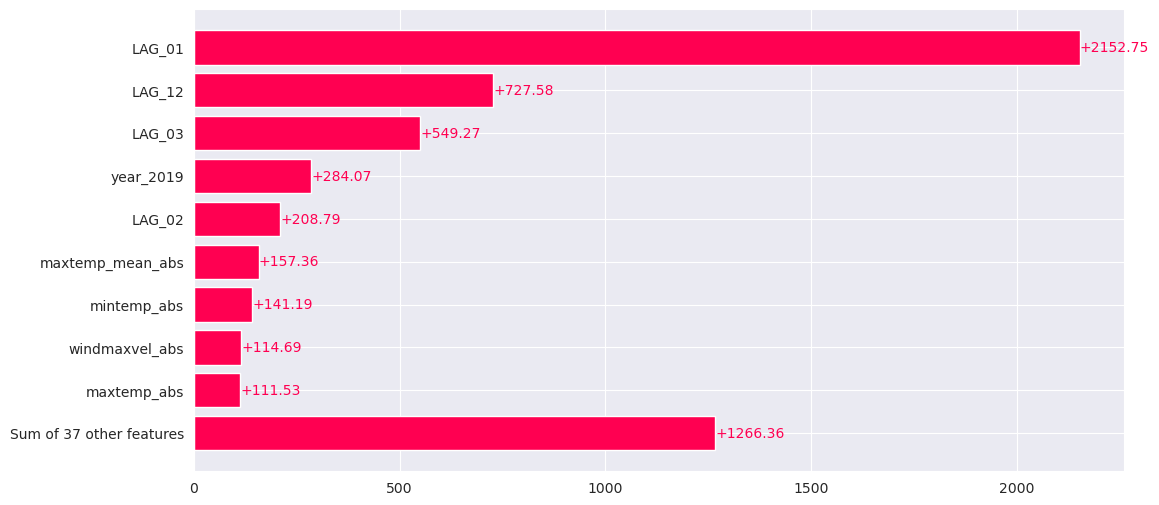

,feature,Mean RF/XGB importance
38,year_2017,0.000000
33,month_AGO,0.514261
31,month_JUN,0.897117
44,year_2023,1.530178
37,month_DEZ,1.652197
34,month_SET,1.837470
30,month_MAI,2.104153
42,year_2021,2.136613
32,month_JUL,2.299665
45,year_2024,2.979547


In [11]:
importance_electr = pandas.DataFrame(list(zip(x_electricity.columns, (
        numpy.abs(shap_rf_electr.values).mean(0) + numpy.abs(shap_xgb_electr.values).mean(0)) / 2)),
                                     columns=["feature", "Mean RF/XGB importance"])
importance_electr = importance_electr.sort_values(by=["Mean RF/XGB importance"], ascending=False)

plt.figure(figsize=(12, 6))

bar_features_electr = list(importance_electr[0:9]["feature"])
bar_features_electr.append(f"Sum of {len(importance_electr[9:])} other features")
bar_importances_electr = list(importance_electr[0:9]["Mean RF/XGB importance"])
bar_importances_electr.append(importance_electr[9:]["Mean RF/XGB importance"].sum())

bar_features_electr = bar_features_electr[::-1]
bar_importances_electr = bar_importances_electr[::-1]

bars = plt.barh(bar_features_electr, bar_importances_electr, color=colors.red_rgb)

for bar, importance in zip(bars, bar_importances_electr):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'+{importance:.2f}',
             va='center', ha='left', color=colors.red_rgb)

plt.show()
importance_electr = importance_electr.sort_values(by=["Mean RF/XGB importance"])
importance_electr


# Seleção de Features


In [12]:
importance_electr = importance_electr.sort_values(by=["Mean RF/XGB importance"])


def ft_removal_rf(n_ft_removed, dataset):
    df_selected = dataset[n_ft_removed:]["feature"]
    x = df_electricity[df_selected]
    y = df_electricity["consumption"]

    rf_fs_electr = CudaRandomForest(n_bins=x.shape[0], random_state=SEED)

    cvs_rf = []
    for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
        x_train, x_test = x.iloc[i_train].to_cupy(), x.iloc[i_test].to_cupy()
        y_train, y_test = y.iloc[i_train].to_cupy(), y.iloc[i_test].to_cupy()

        rf_fs_electr.fit(x_train, y_train)
        cvs_rf.append(int(mean_absolute_error(y_test, rf_fs_electr.predict(x_test))))
    return int(numpy.array(cvs_rf).mean())


def ft_removal_xgb(n_ft_removed, dataset):
    df_selected = dataset[n_ft_removed:]["feature"]

    x = df_electricity[df_selected]
    y = df_electricity["consumption"]

    xgb_fs_electr = XGBRegressor(booster="gbtree", device="cuda", random_state=SEED)

    cvs_xgb = []
    for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
        x_train, x_test = x.iloc[i_train].to_cupy(), x.iloc[i_test].to_cupy()
        y_train, y_test = y.iloc[i_train].to_cupy(), y.iloc[i_test].to_cupy()

        xgb_fs_electr.fit(x_train, y_train)
        cvs_xgb.append(int(mean_absolute_error(y_test, xgb_fs_electr.predict(x_test))))

    return int(numpy.array(cvs_xgb).mean())


importance_electr = importance_electr.sort_values(by=["Mean RF/XGB importance"])

ft_rm_rf_electr = dask.compute(
    [dask.delayed(ft_removal_rf)(i, importance_electr) for i in range(importance_electr["feature"].shape[0])])[0]
ft_rm_xgb_electr = dask.compute(
    [dask.delayed(ft_removal_xgb)(i, importance_electr) for i in range(importance_electr["feature"].shape[0])])[0]


/home/eduardo/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/eduardo/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/eduardo/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducib

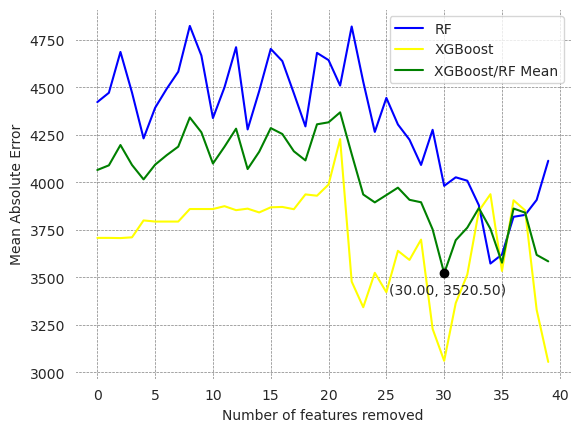

,consumption,LAG_01,LAG_02,LAG_03,LAG_04,LAG_06,LAG_09,LAG_12,meantemp,maxtemp_abs,maxtemp_mean_abs,mintemp_abs,windmaxvel_abs,windmaxvel_mean_abs,month_JAN,month_MAR,year_2019
date,,,,,,,,,,,,,,,,,
2019-01-01,10732.0,20426.0,19998.0,20174.0,21969.0,17751.0,21052.0,10280.0,21.900000,31.799999,28.320000,16.200001,15.800000,9.74,1.0,0.0,1.0
2019-02-01,17208.0,10732.0,20426.0,19998.0,20174.0,22575.0,21095.0,14487.0,19.690001,30.900000,25.879999,13.500000,14.800000,9.50,0.0,0.0,1.0
2019-03-01,19451.0,17208.0,10732.0,20426.0,19998.0,21969.0,20841.0,18671.0,19.020000,30.000000,25.370001,10.800000,13.400000,8.69,0.0,1.0,1.0
2019-04-01,23949.0,19451.0,17208.0,10732.0,20426.0,20174.0,17751.0,21052.0,18.070000,28.900000,24.139999,7.800000,13.900000,7.93,0.0,0.0,1.0
2019-05-01,24015.0,23949.0,19451.0,17208.0,10732.0,19998.0,22575.0,21095.0,15.920000,27.900000,20.660000,7.600000,14.000000,8.46,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,12207.0,11286.0,11897.0,21955.0,21165.0,16964.0,13555.0,14326.0,19.270000,31.900000,24.910000,4.300000,16.200001,9.30,0.0,0.0,0.0
2023-12-01,9588.0,12207.0,11286.0,11897.0,21955.0,16655.0,15342.0,12500.0,20.959999,33.299999,27.150000,11.800000,15.700000,8.69,0.0,0.0,0.0
2024-01-01,8226.0,9588.0,12207.0,11286.0,11897.0,21165.0,14480.0,10272.0,20.180000,31.000000,26.299999,10.600000,16.700001,9.21,1.0,0.0,0.0


In [16]:
ft_rm_mean_electr = (np.array(ft_rm_rf_electr) + np.array(ft_rm_xgb_electr)) / 2
min_index = np.argmin(ft_rm_mean_electr[:40])

plt.plot([x for x in ft_rm_rf_electr[:40]], label="RF", color="blue")
plt.plot([x for x in ft_rm_xgb_electr[:40]], label="XGBoost", color="yellow")
plt.plot([x for x in ft_rm_mean_electr[:40]], label="XGBoost/RF Mean", color="green")
plt.scatter(min_index, ft_rm_mean_electr[min_index], color='black', zorder=2)
plt.annotate(f"({min_index:.2f}, {ft_rm_mean_electr[min_index]:.2f})", xy=(min_index, ft_rm_mean_electr[min_index]),
             xytext=(-40, -15), textcoords='offset points', fontsize=10)

plt.xlabel('Number of features removed')
plt.ylabel('Mean Absolute Error')
ax = plt.gca()
ax.set_facecolor('white')
plt.grid(True, color='grey', linestyle="--", linewidth=0.5)
plt.legend(facecolor='white')
plt.show()
importance_electr = importance_electr.sort_values(by=["Mean RF/XGB importance"])
df_electricity_selected = df_electricity.drop(importance_electr[:min_index]["feature"], axis=1)
df_electricity_selected.to_pandas().to_csv(f"dataset/elect_merged_selected.csv", sep=";", decimal=",")
df_electricity_selected